In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
#from lwautils import lwa_arx 
import pandas as pd
from cr_data_inspection_functions import *
import struct
import math
from lwa_antpos import mapping
import os

dsautils.cnf not found. skipping...
Read antpos from etcd


In [77]:
#fname='/home/ubuntu/kp/data/2023April4/packetwait60001680654937.4761376.dat'
#fname='/home/ubuntu/kp/data/2023April4/packetwait6000_triggersnap041680656108.0096362.dat'
#fname='/home/ubuntu/kp/data/2023April5/file5events1680708308.1066167.dat' #five "events" (triggers from software) in one file
#fname='/home/ubuntu/kp/data/2023April5/file5events_aftersync1680727473.3673108.dat' #trying again after redoing synchronization and setup
#fname='/home/ubuntu/kp/data/2023April6/test5events1680827775.852633.dat'  #new firmware
#fname='/home/ubuntu/kp/data/2023April16/test_new_firmware_for_timestamp_fix_packetwait60001681693266.5600955.dat'
#fname='/home/ubuntu/kp/data/2023April18-nighttime/internaltrigger1681882016.5401862.dat' #from internal trigger Tuesday night April 18
#fname='/home/ubuntu/kp/data/2023April20/overnight_software_snapshots1682051758.6163533.dat'
#fname='/home/ubuntu/kp/data/2023April21/midday-test1682100866.8684964.dat'
#fname='/home/ubuntu/kp/data/2023April21/singlesnapshot-evening1682135222.9255564.dat'
#fname='/home/ubuntu/kp/data/2023May3/wait0buffer1683177898.7706654.dat'
#fname='/home/ubuntu/kp/data/2023May3/wait2000buffer1683177949.2851286.dat'
fname='/home/ubuntu/kp/data/2023May3/wait3000buffer1683179064.7373273.dat'
records=parsefile(fname)

File contains  1408  packets


In [78]:
packetboardids=[record['board_id'] for record in records]
timestamps=[record['timestamp'] for record in records]

In [79]:
for i in range(11):
    count=0
    for b in packetboardids:
        if i+1==b:
            count+=1
    print('Got ',count,' packets from snap',i+1, ' which is ', count/64, ' snapshots')

Got  128  packets from snap 1  which is  2.0  snapshots
Got  130  packets from snap 2  which is  2.03125  snapshots
Got  128  packets from snap 3  which is  2.0  snapshots
Got  128  packets from snap 4  which is  2.0  snapshots
Got  128  packets from snap 5  which is  2.0  snapshots
Got  128  packets from snap 6  which is  2.0  snapshots
Got  126  packets from snap 7  which is  1.96875  snapshots
Got  128  packets from snap 8  which is  2.0  snapshots
Got  128  packets from snap 9  which is  2.0  snapshots
Got  128  packets from snap 10  which is  2.0  snapshots
Got  128  packets from snap 11  which is  2.0  snapshots


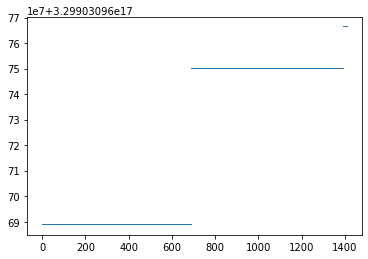

In [80]:
plt.plot(timestamps,',')
#plt.ylim(3.2942e17,3.2943e17)


-122


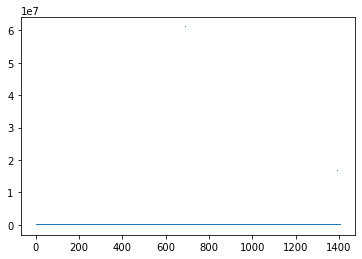

In [81]:
difference_timestamps=[timestamps[i+1]-timestamps[i] for i in range(len(timestamps)-1)]
plt.plot(difference_timestamps,',')
print(np.min(difference_timestamps))

## Function for sorting packets into events

    

In [82]:

def distinguishevents(records,maxoffset):
    #This function turns a list of single-antenna records, into a list of events.
    #records is a list of single-antenna records, such as that returned by parsefile.
    #maxoffset is the maximum timestamp difference (in number of clockcycles) for two records to be considered part of the same event.
    #The function distinguish events returns a list of events, where each event is a list of the records (single-antenna dictionaries) that belong to that event.

    #start an empty list which will ultimately have one element per event
    events=[]
    #eventcount=1  #keep track of how many separate events there are

    #start an list for the first event. The first record is the first element of the first event
    currentevent=[]
    currenteventtimestamp=records[0]['timestamp']

    maxtimestamp=currenteventtimestamp+maxoffset #all
    mintimestamp=currenteventtimestamp-maxoffset
    for record in records:
        recordtimestamp=record['timestamp']
        if mintimestamp<recordtimestamp<maxtimestamp:
            #print(recordtimestamp, maxtimestamp,True)
            currentevent.append(record)
        else: #start a new event
            #print(recordtimestamp, maxtimestamp,False)
            #eventcount+=1
            events.append(currentevent)
            currentevent=[record]
            currenteventtimestamp=record['timestamp']
            maxtimestamp=currenteventtimestamp+maxoffset
    events.append(currentevent)
    return events
        

In [83]:
maxoffset=200 #maximum number of clock cycles difference allowed between packets that are part of the same event
events=distinguishevents(records,maxoffset)

3
688
16 704


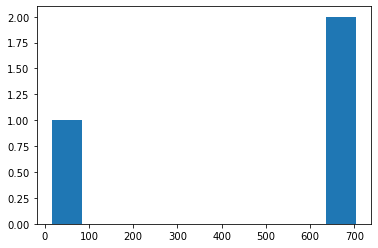

In [84]:
print(len(events))
print(len(events[0]))
all_event_sizes=np.asarray([len(e) for e in events])
plt.hist(all_event_sizes)
print(np.min(all_event_sizes),np.max(all_event_sizes))

In [85]:
#separate event records by board
#for each board, plot the timeseries in an 8x8 grid
#label the plots by antenna name
#add an option to instead plot histogram or power spectrum

In [86]:
def plot_all_timeseries(event):
    for b in range(11):
        singleboard=[record for record in event if record['board_id']==b+1]
        fig=plt.figure(figsize=(20,15))
        plt.suptitle("Board "+str(b+1)+" timestamp "+str(singleboard[0]['timestamp']))
        for i in range(64):
            ax=fig.add_subplot(8,8,1+i)
            if i<len(singleboard):
                record=singleboard[i]
                antenna=packet_ant_id_2_snap_input(record['antenna_id']) #Get the snap2 input number
                antname=mapping.snap2_to_antpol(b+1,antenna) #TODO zero index the boards or 1-index??

                timeseries=record['data']
                plt.plot(timeseries)
                ax.text(.5,.5,antname,horizontalalignment='center',transform=ax.transAxes)
            if i > 55:
                plt.xlabel('time sample')
            if i%8==0:
                plt.ylabel('voltage [ADC units]')
    return

def plot_all_spectra(event):

    for b in range(11):
        singleboard=[record for record in event if record['board_id']==b+1]
        fig=plt.figure(figsize=(20,15))
        plt.suptitle("Board "+str(b+1)+" timestamp "+str(singleboard[0]['timestamp']))
        for i in range(64):
            ax=fig.add_subplot(8,8,1+i)
            if i<len(singleboard):
                record=singleboard[i]
                antenna=packet_ant_id_2_snap_input(record['antenna_id']) #Get the snap2 input number
                antname=mapping.snap2_to_antpol(b+1,antenna) #TODO zero index the boards or 1-index??
                timeseries=record['data']
                spec=np.fft.rfft(timeseries)
                plt.plot(np.log(np.square(np.abs(spec))))
                ax.text(.5,.5,antname,horizontalalignment='center',transform=ax.transAxes)
            if i > 55:
                plt.xlabel('frequency channel')
            if i%8==0:
                plt.ylabel('power')
    return

def plot_all_histograms(event):
    for b in range(11):
        singleboard=[record for record in event if record['board_id']==b+1]
        fig=plt.figure(figsize=(20,15))
        plt.suptitle("Board "+str(b+1)+" timestamp "+str(singleboard[0]['timestamp']))
        for i in range(64):
            ax=fig.add_subplot(8,8,1+i)
            if i<len(singleboard):
                record=singleboard[i]
                antenna=packet_ant_id_2_snap_input(record['antenna_id']) #Get the snap2 input number
                antname=mapping.snap2_to_antpol(b+1,antenna) #TODO zero index the boards or 1-index??

                timeseries=record['data']
                plt.hist(timeseries)
                ax.text(.5,.5,antname,horizontalalignment='center',transform=ax.transAxes)

            if i > 55:
                plt.xlabel('Voltage [ADC units]')
            if i%8==0:
                plt.ylabel('Counts')
    return

def plot_select_antennas(event,antennas):
    #Event is a list of records (single-packet dictionaries) belonging to the same event
    #antennas is a list where each element in the list is a tuple of format (s,a) where s is the index of the snap board and a is the index of the antenna to plot
    #If a requested antenna to plot is not in the list (which happens if that packet has been lost), the missing antenna is skipped
    #The requested antennas are plotted in the order they appear in event, not in the order of the input list
    for record in event:
        s=record['board_id']
        a=record['antenna_id']
        antname=mapping.snap2_to_antpol(s,a)
        if (s,a) in antennas:
            timeseries=record['data']
            plt.figure(figsize=(20,5))
            plt.suptitle(antname + ' snap '+ str(s) + ' antenna ' + str(a))
            
            plt.subplot(131)
            plt.plot(timeseries)
            plt.xlabel('time sample')
            plt.ylabel('voltage [ADC units]')

            plt.subplot(132)
            plt.hist(timeseries)
            plt.xlabel('Voltage [ADC units]')
            plt.ylabel('Counts')

            plt.subplot(133)
            plt.xlabel('frequency channel')
            plt.ylabel('power')
            spec=np.fft.rfft(timeseries)
            plt.plot(np.log(np.square(np.abs(spec))))
            

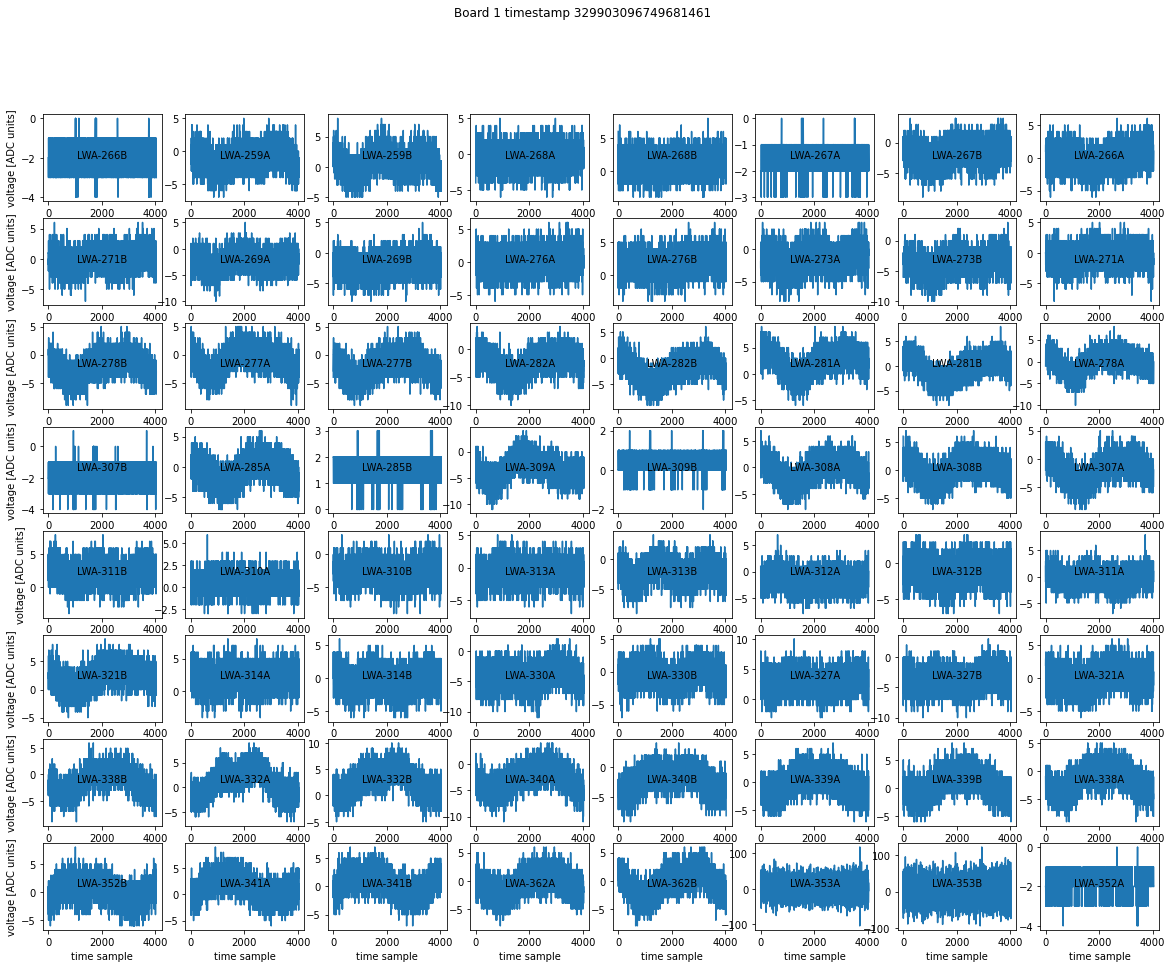

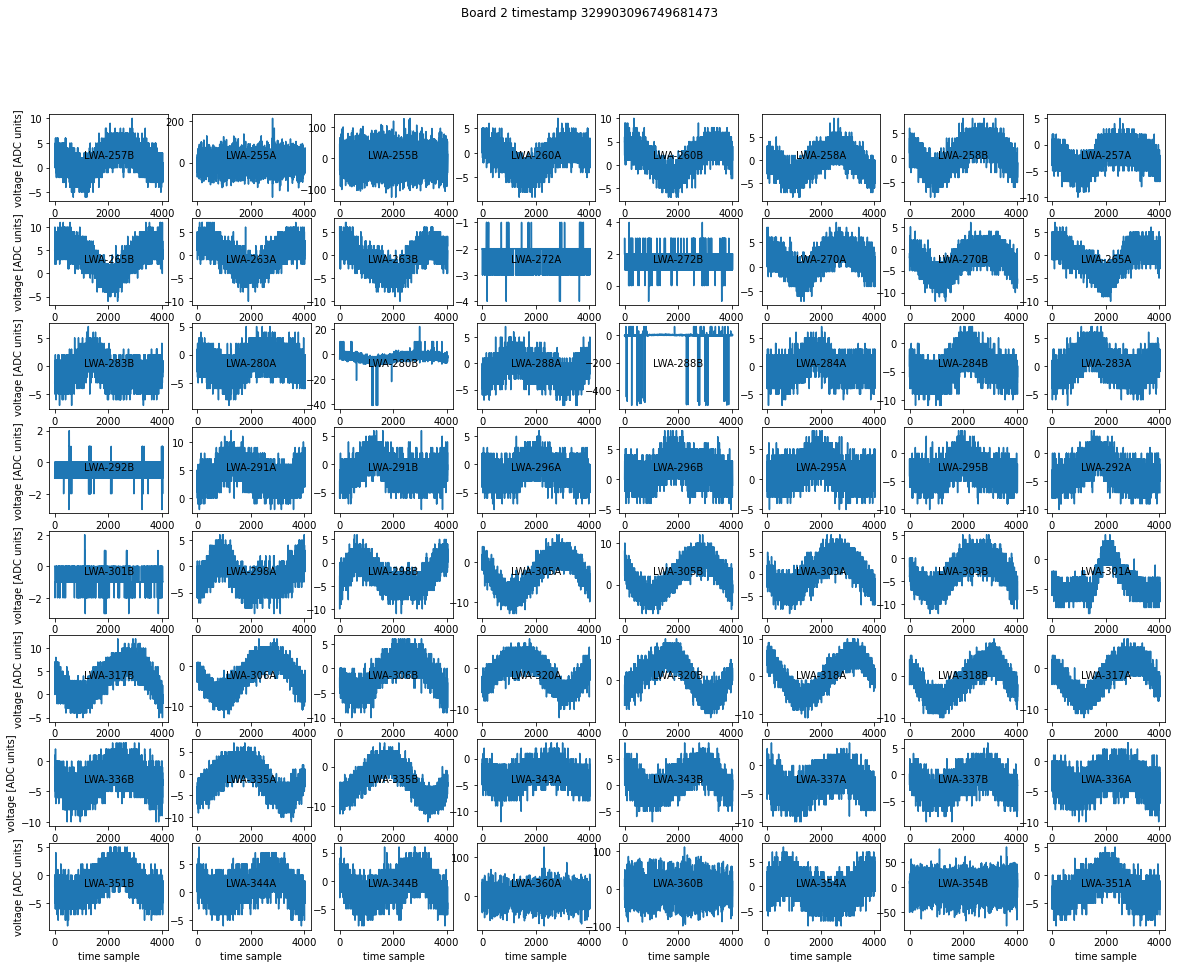

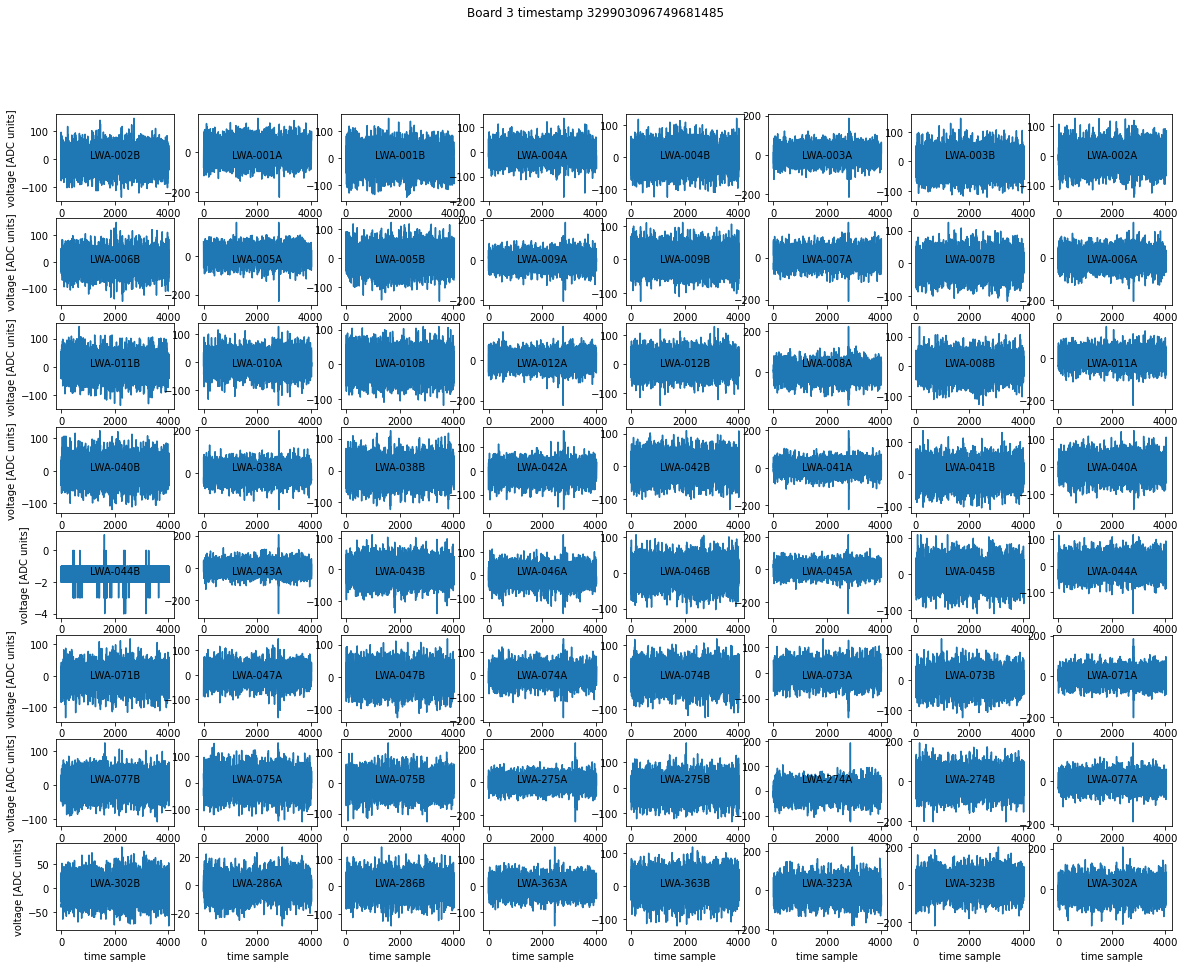

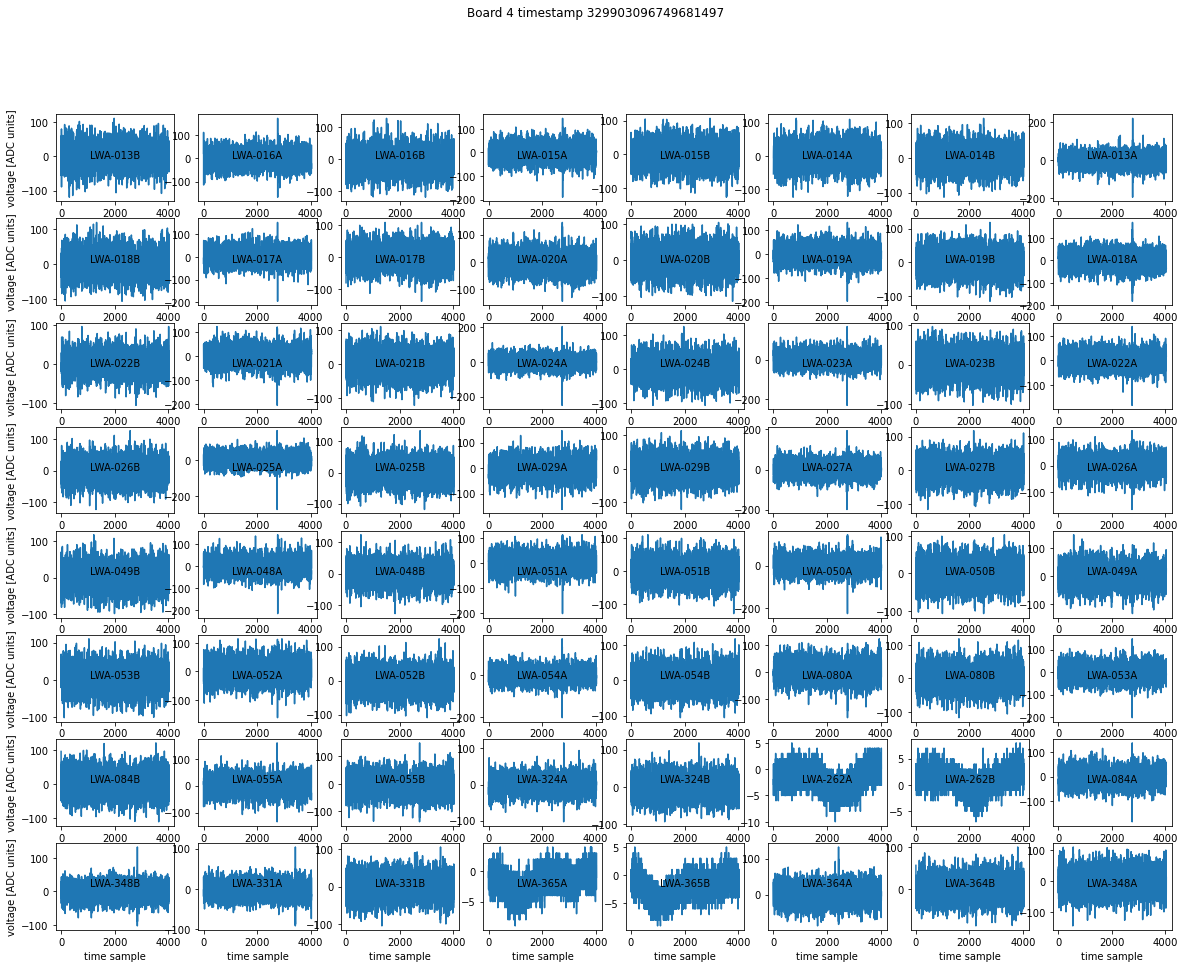

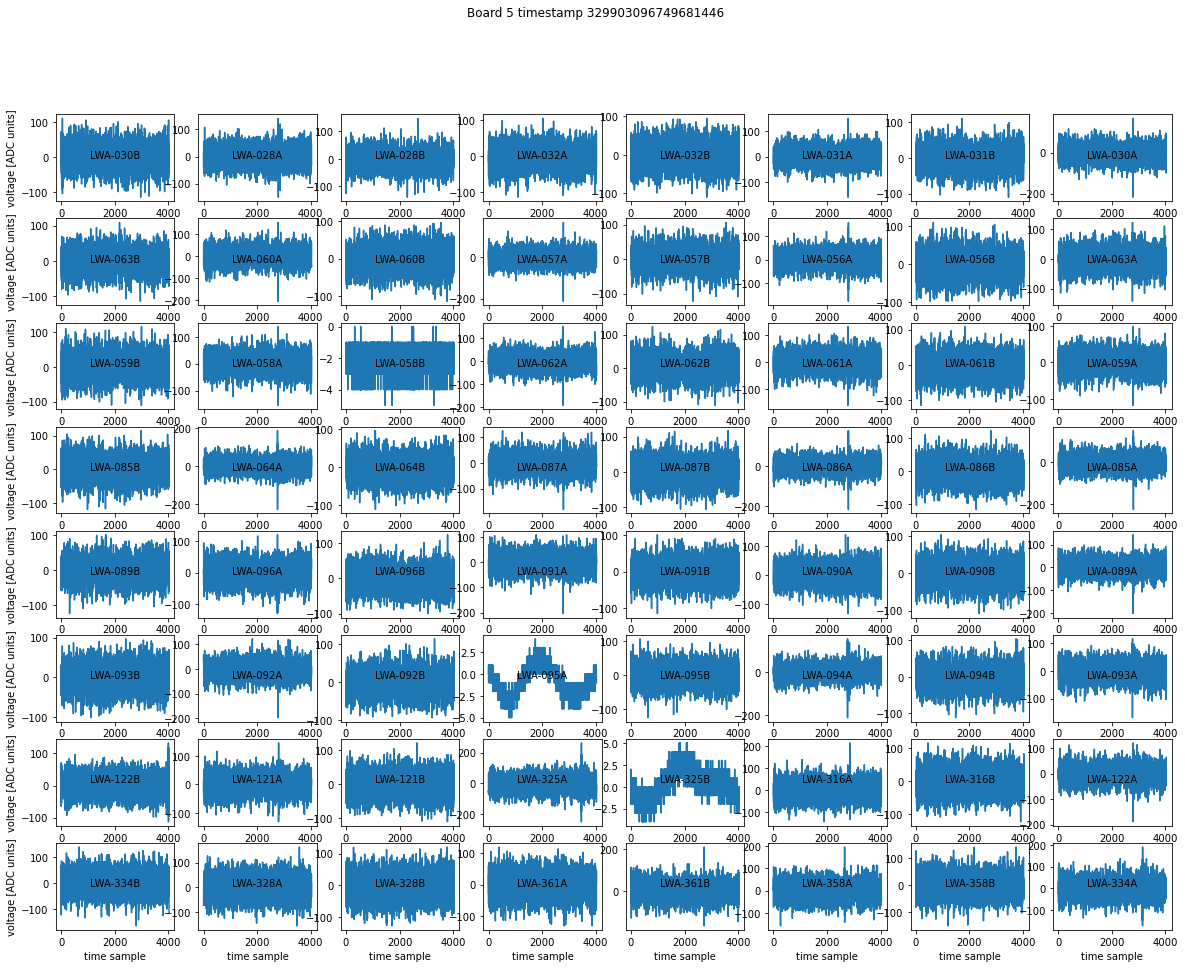

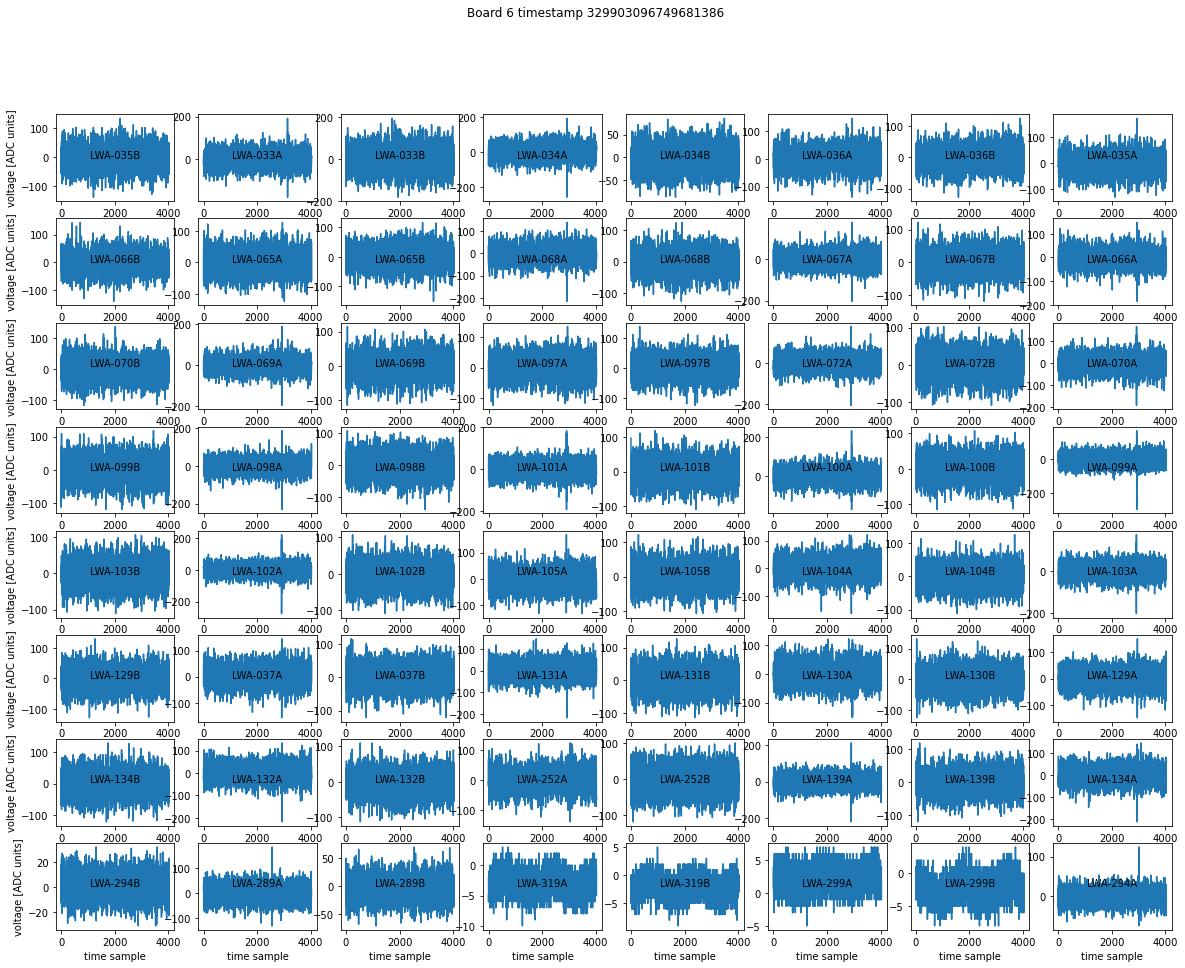

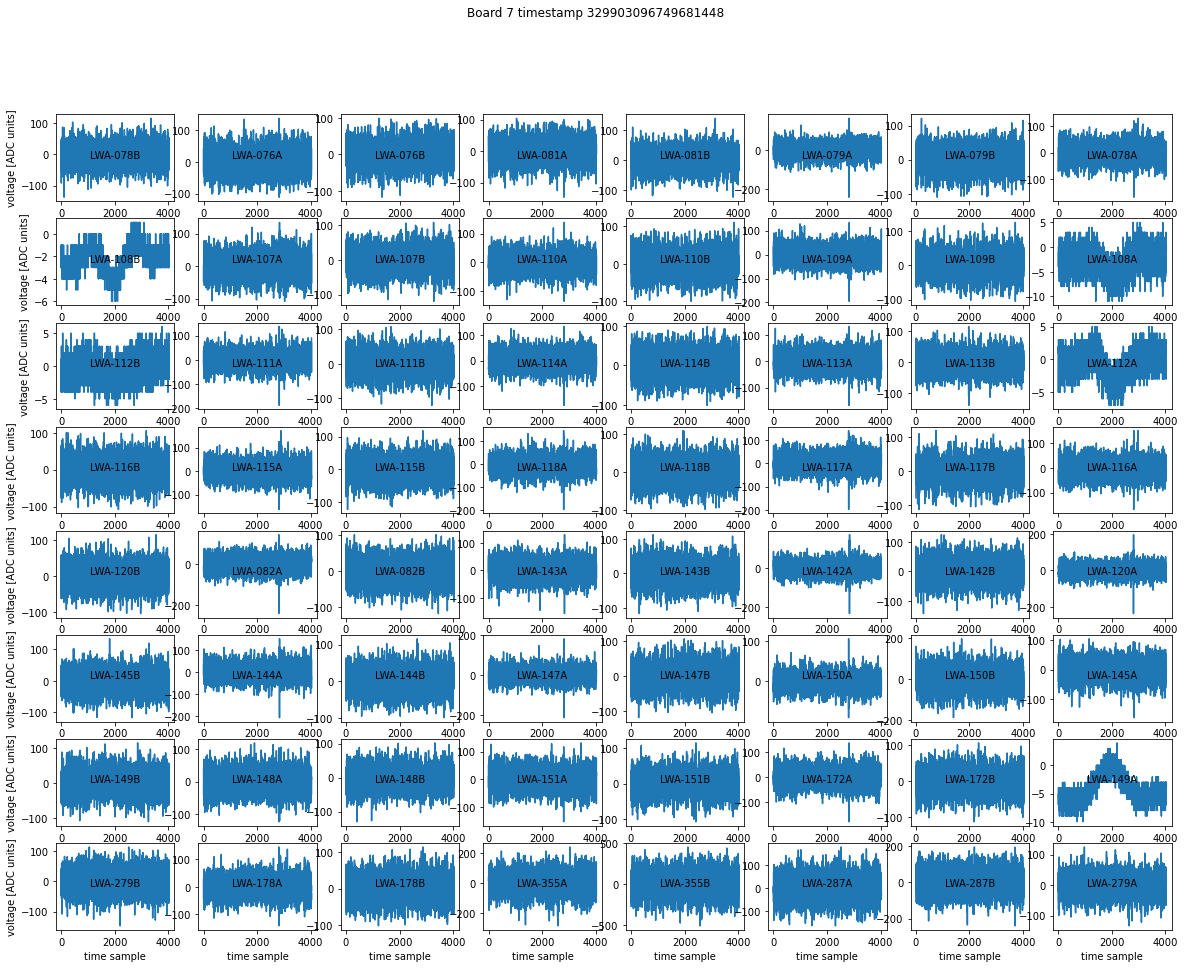

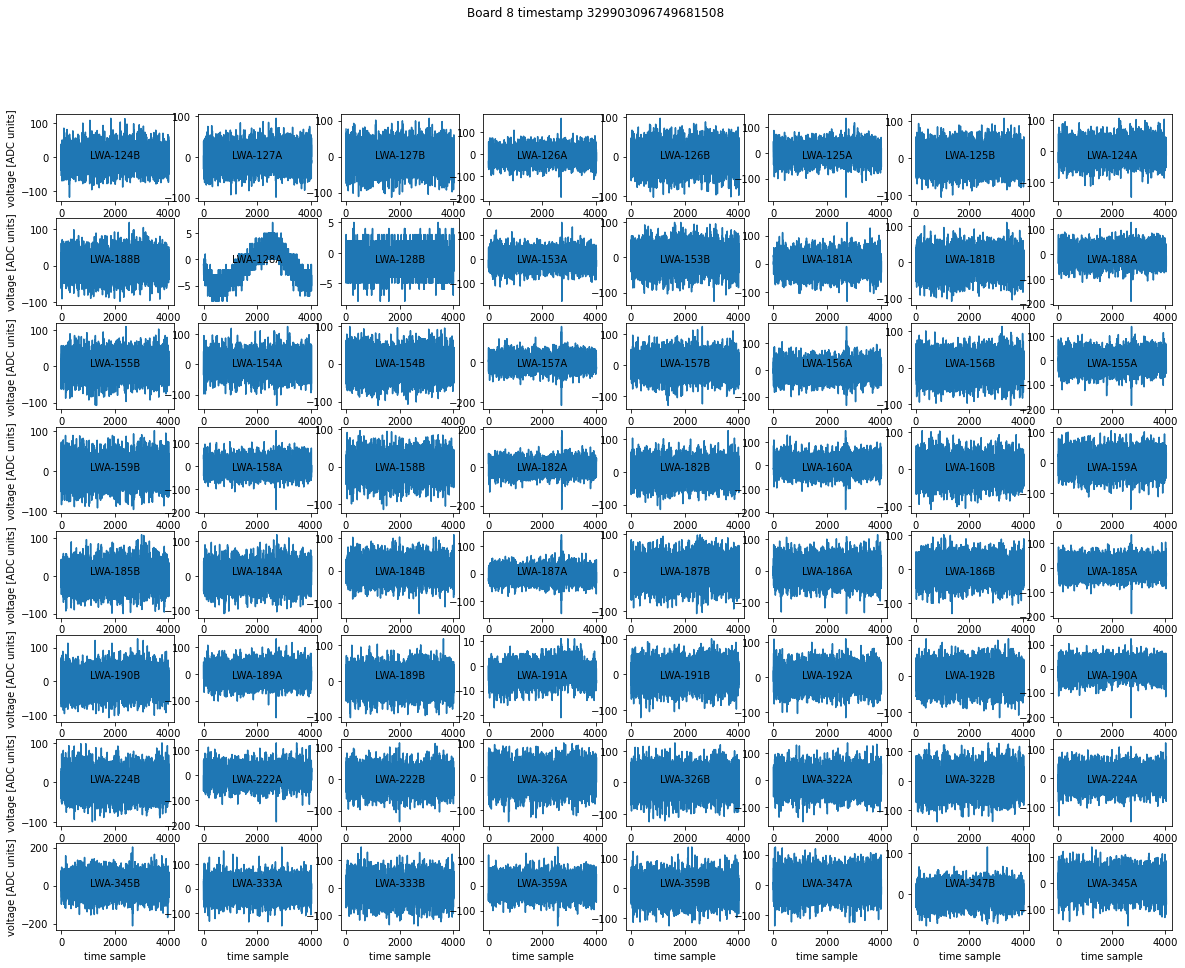

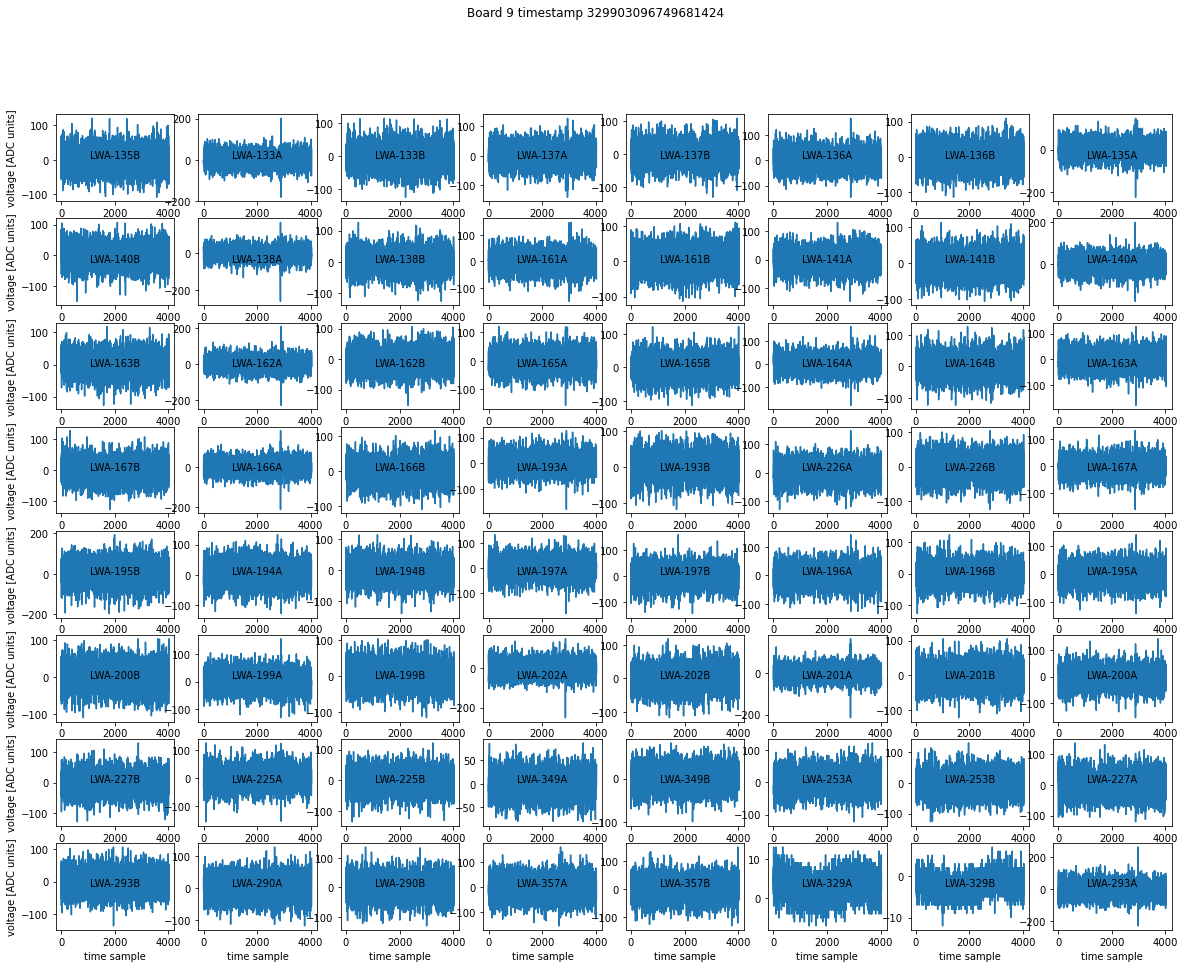

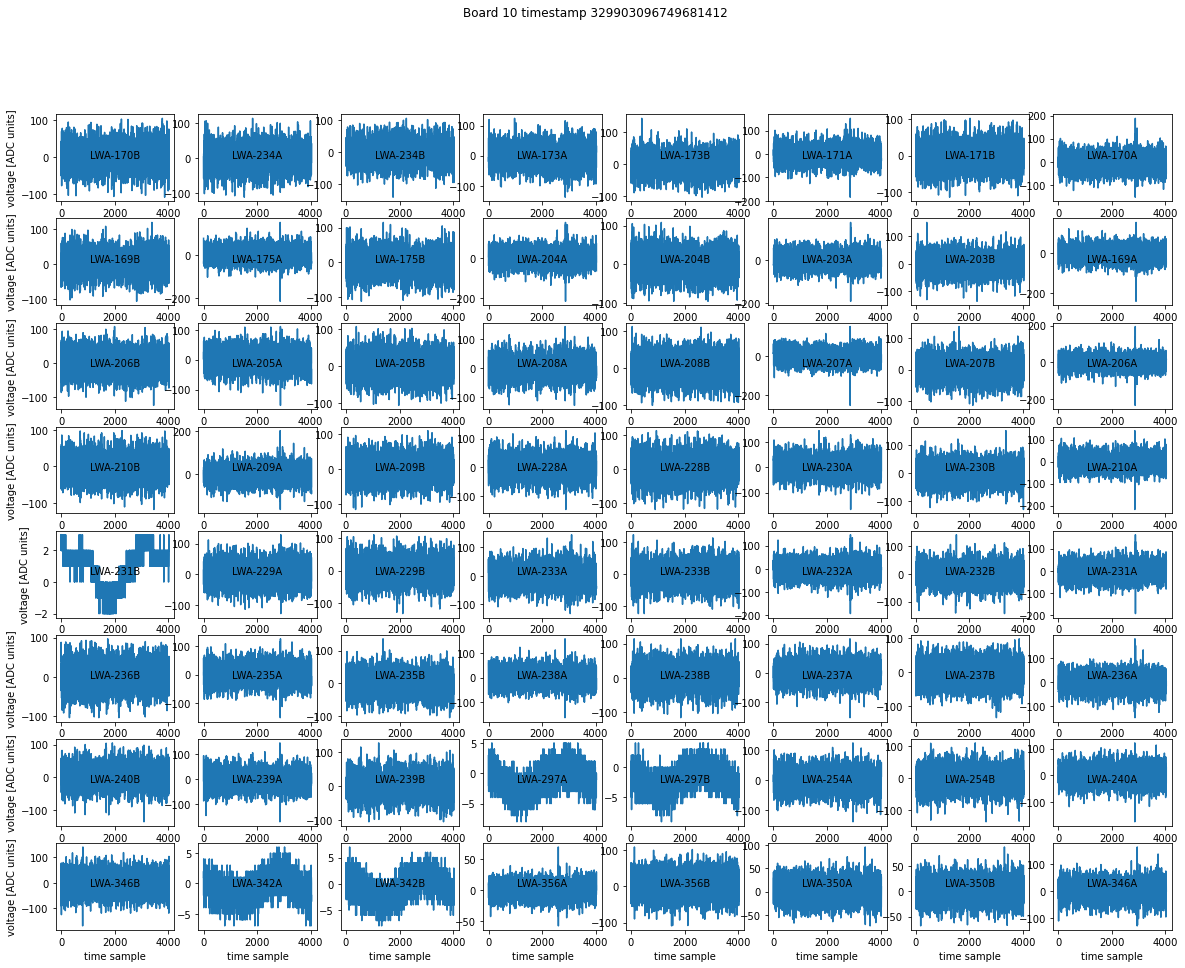

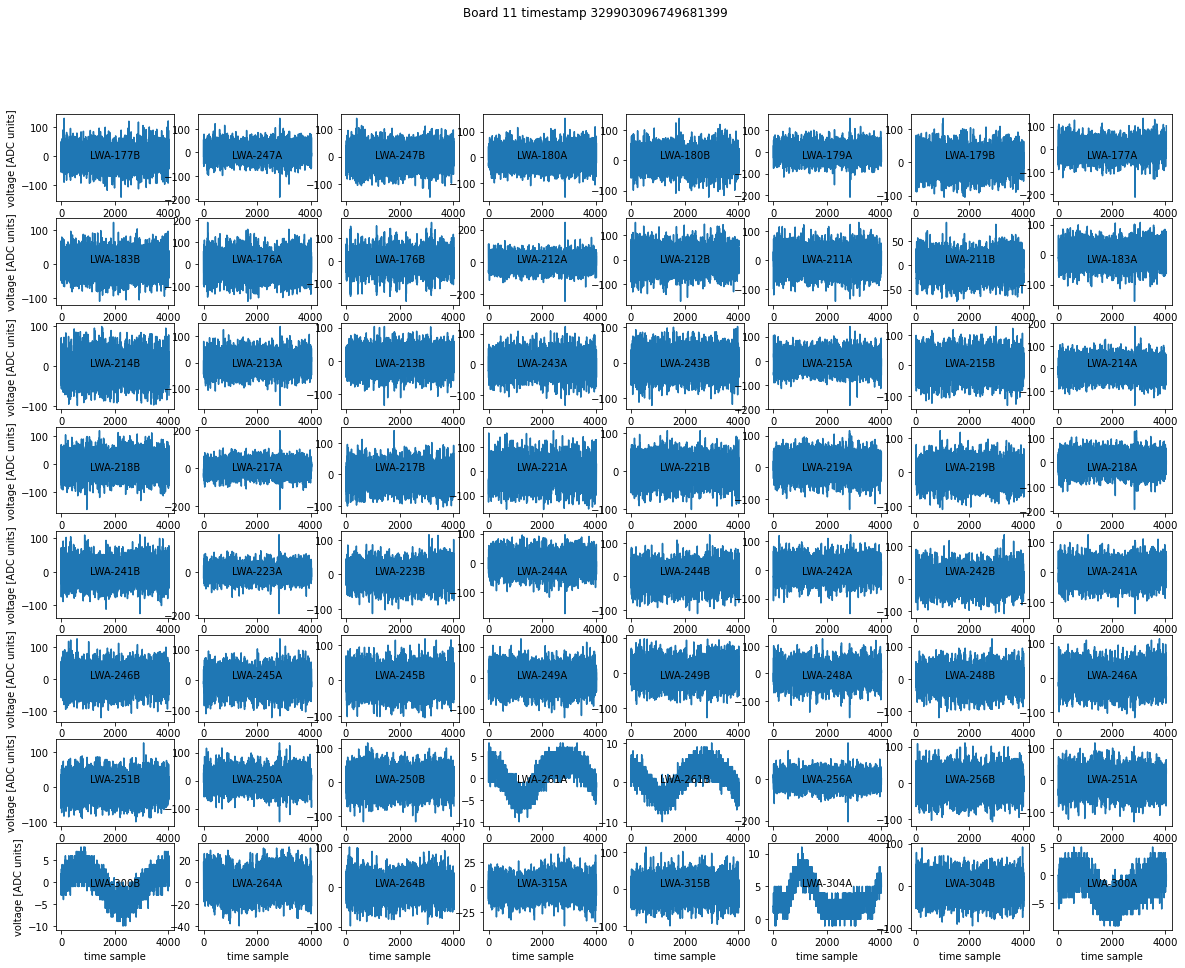

In [87]:
plot_all_timeseries(events[1])


LWA-326A (8, 52)
LWA-326B (8, 53)
LWA-322A (8, 54)
LWA-322B (8, 55)
LWA-333A (8, 58)
LWA-333B (8, 59)
LWA-077A (3, 48)
LWA-077B (3, 49)
LWA-075A (3, 50)
LWA-075B (3, 51)


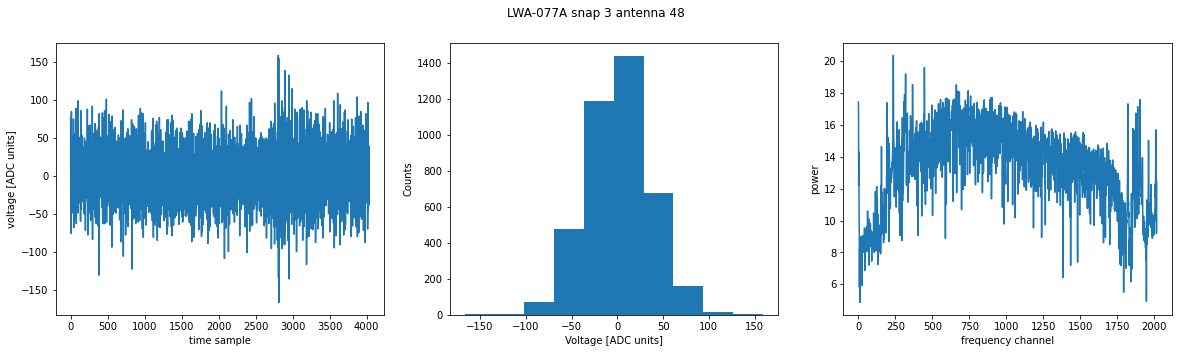

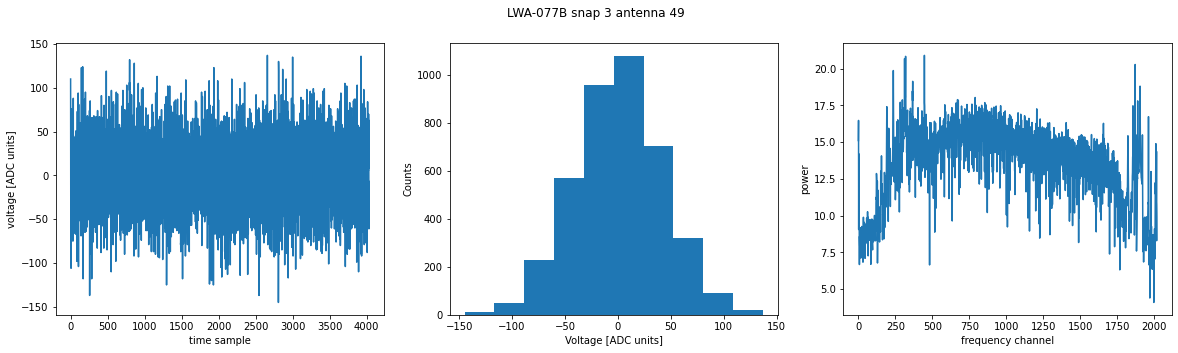

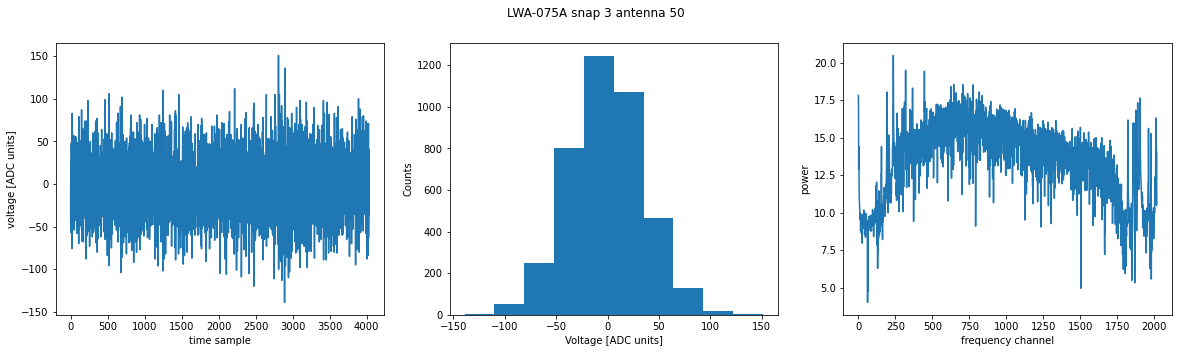

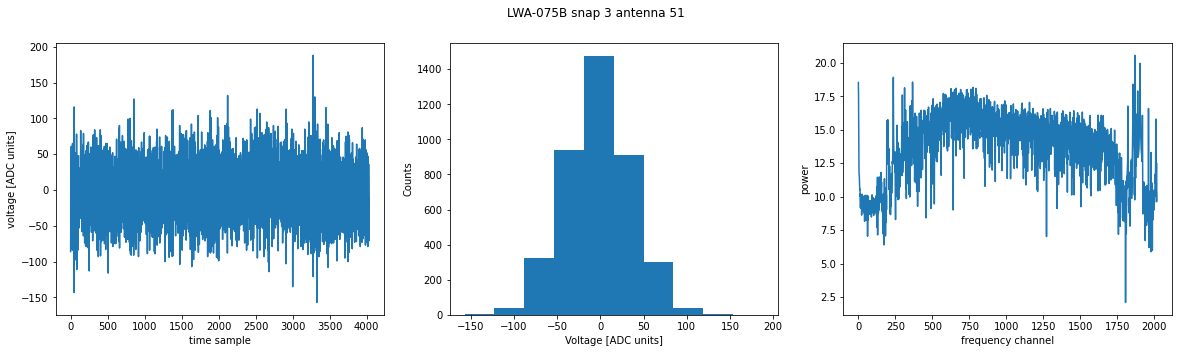

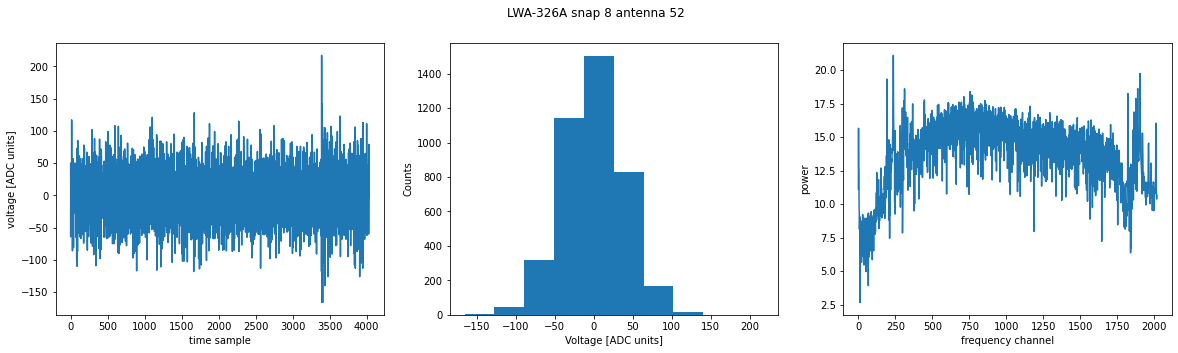

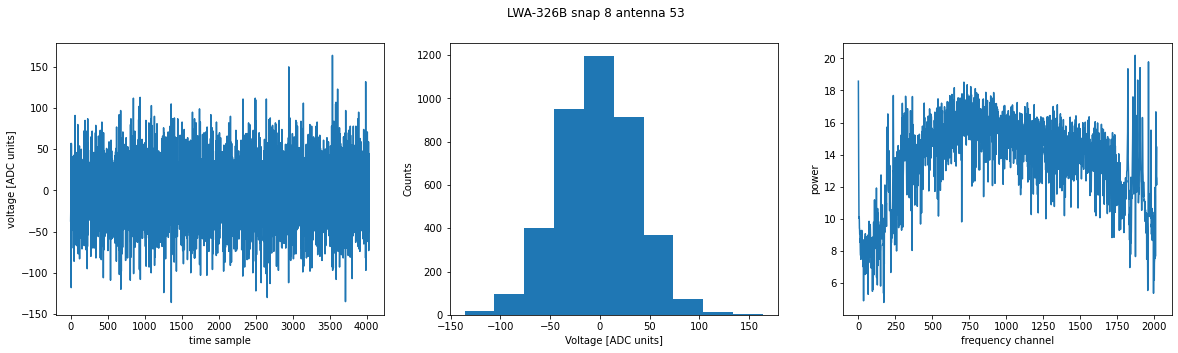

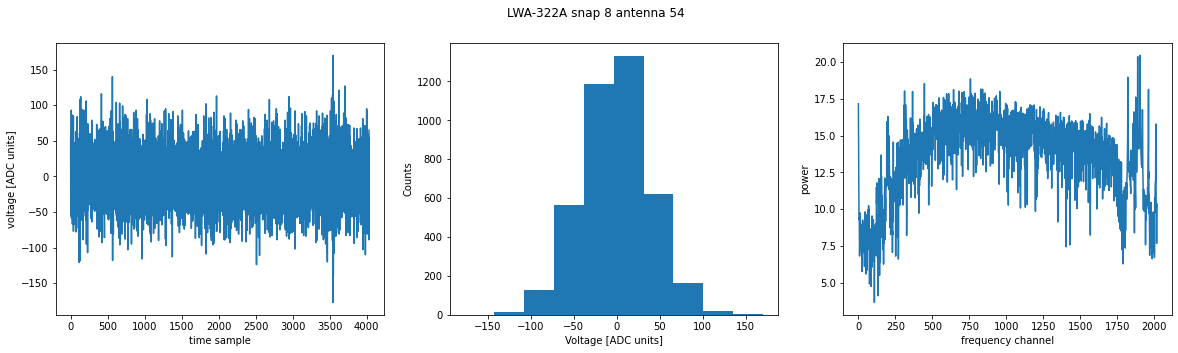

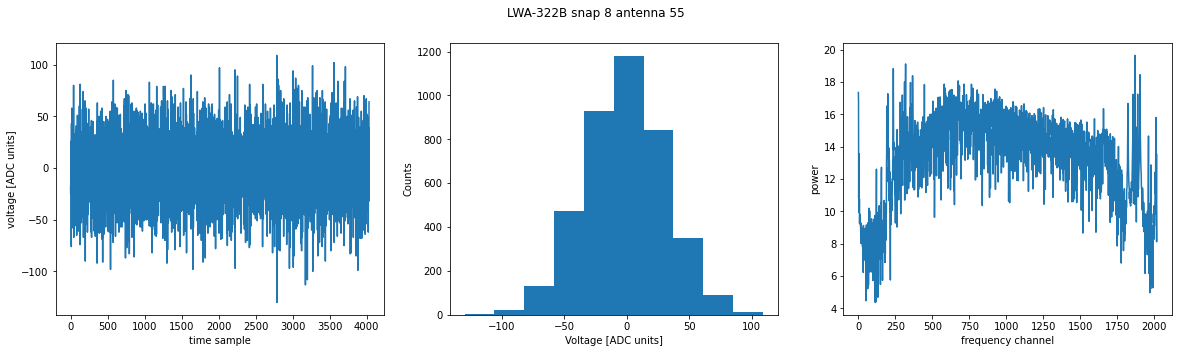

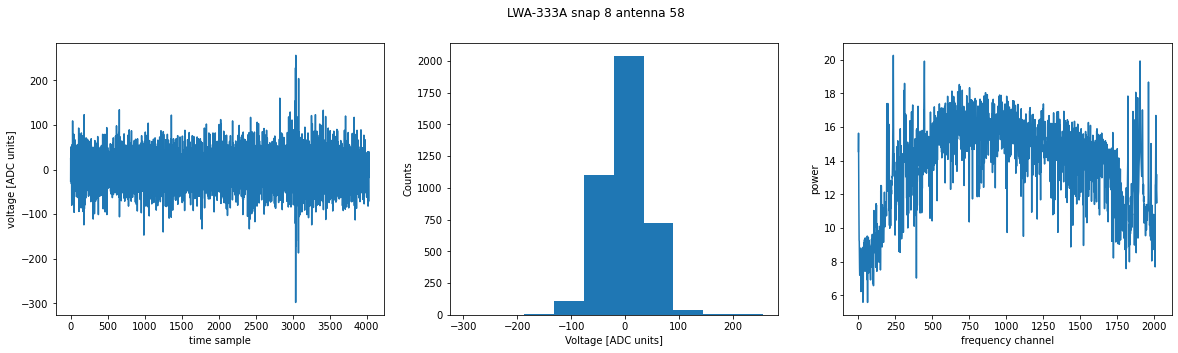

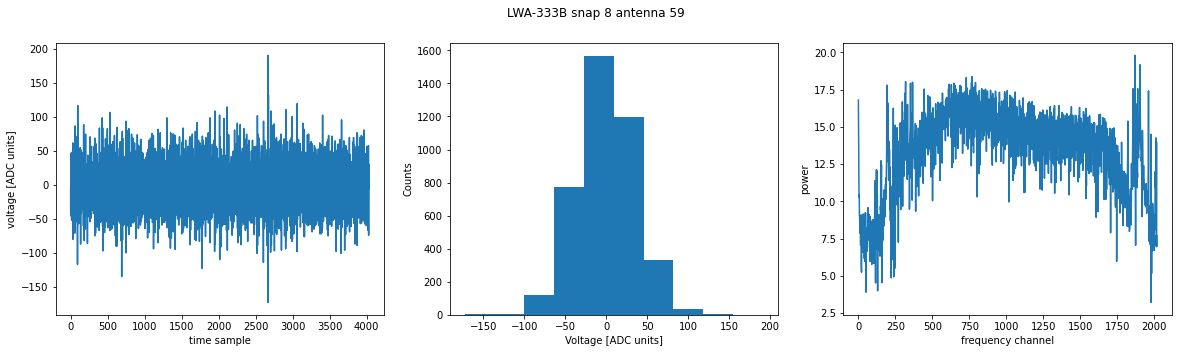

In [53]:

#new_fiber_antennas=['LWA-274A','LWA-274B',
#                          'LWA-302A', 'LWA-302B',
#                          'LWA-323A', 'LWA-323B', 
#                          'LWA-346A', 'LWA-346B',
#                         'LWA-349A',  'LWA-349B', 
#                          'LWA-350A',  'LWA-350B',
#                          'LWA-356A',  'LWA-356B']

antennas_to_plot=['LWA-326A','LWA-326B',
                  'LWA-322A','LWA-322B',
                  'LWA-333A','LWA-333B',
                  'LWA-077A','LWA-077B',
                  'LWA-075A','LWA-075B']
                  

antennas=[mapping.antpol_to_fpga(antname[:-1],antname[-1]) for antname in antennas_to_plot]
[print(antennas_to_plot[i],antennas[i]) for i in range(len(antennas_to_plot))]
plot_select_antennas(events[1],antennas)


In [64]:
#plot_all_spectra(events[0])
#plot_all_spectra(records)


In [65]:
#plot_all_histograms(events[0])
#plot_all_histograms(records)


In [ ]:
antennas=[mapping.antpol_to_fpga(antname[:-1],antname[-1]) for antname in ['LWA-274B']]
for i in range(20):
    plot_select_antennas(events[i],antennas)

## Create a way to check which veto antennas are available from a snapshot.

In [15]:
fname='/home/ubuntu/kp/data/2023April27/testsnapshot1682653701.710574.dat'
fname='/home/ubuntu/kp/data/2023May3/snapshot-to-check-veto-status1683171255.1772912.dat'

records=parsefile(fname)
for r in records:
    timeseries=r['data']
    r['rms']=np.std(timeseries)
    r['absmax']=np.max(np.abs(timeseries))

File contains  704  packets


In [16]:
rms=[r['rms'] for r in records]
absmax=[r['absmax'] for r in records]

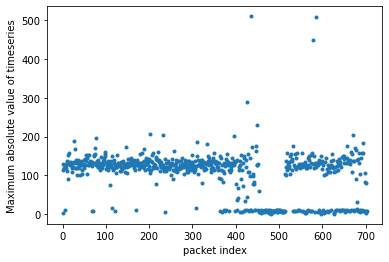

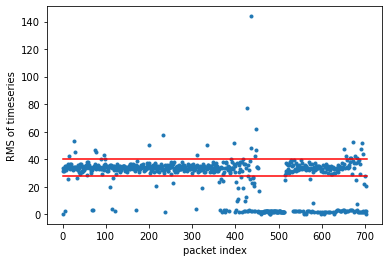

In [17]:
plt.plot(absmax,'.')
plt.xlabel('packet index')
plt.ylabel('Maximum absolute value of timeseries')
plt.figure()
plt.plot(rms,'.')
plt.ylabel('RMS of timeseries')
plt.xlabel('packet index')
plt.plot([0,704],[28,28],'r')
plt.plot([0,704],[40,40],'r')

#plt.ylim(-1,100)

In [18]:
brdnames=['snap01','snap02','snap03','snap04','snap05','snap06','snap07','snap08','snap09','snap10','snap11']

veto_antennas_names={}
veto_antennas_names['snap08']=['LWA-322','LWA-326','LWA-333','LWA-347']
veto_antennas_names['snap05']=['LWA-328','LWA-325','LWA-334','LWA-316']
veto_antennas_names['snap10']=['LWA-297','LWA-350','LWA-356','LWA-342']
veto_antennas_names['snap11']=['LWA-264','LWA-261','LWA-315','LWA-300']
veto_antennas_names['snap04']=['LWA-331','LWA-348','LWA-364']
veto_antennas_names['snap09']=['LWA-349','LWA-329','LWA-290','LWA-357']
veto_antennas_names['snap07']=['LWA-287','LWA-279','LWA-355']
veto_antennas_names['snap06']=['LWA-319','LWA-299','LWA-289']
veto_antennas_names['snap03']=['LWA-275','LWA-286','LWA-302','LWA-363']
veto_antennas_names['snap01']=[]
veto_antennas_names['snap02']=[]
for snap in brdnames:
    print(snap)
    vetonames=veto_antennas_names[snap]
    for ant in vetonames:
        print(ant,mapping.antpol_to_fpga(ant,'A'))

snap01
snap02
snap03
LWA-275 (3, 52)
LWA-286 (3, 58)
LWA-302 (3, 56)
LWA-363 (3, 60)
snap04
LWA-331 (4, 58)
LWA-348 (4, 56)
LWA-364 (4, 62)
snap05
LWA-328 (5, 58)
LWA-325 (5, 52)
LWA-334 (5, 56)
LWA-316 (5, 54)
snap06
LWA-319 (6, 60)
LWA-299 (6, 62)
LWA-289 (6, 58)
snap07
LWA-287 (7, 62)
LWA-279 (7, 56)
LWA-355 (7, 60)
snap08
LWA-322 (8, 54)
LWA-326 (8, 52)
LWA-333 (8, 58)
LWA-347 (8, 62)
snap09
LWA-349 (9, 52)
LWA-329 (9, 62)
LWA-290 (9, 58)
LWA-357 (9, 60)
snap10
LWA-297 (10, 52)
LWA-350 (10, 62)
LWA-356 (10, 60)
LWA-342 (10, 58)
snap11
LWA-264 (11, 58)
LWA-261 (11, 52)
LWA-315 (11, 60)
LWA-300 (11, 56)


In [19]:


brdnames=['snap01','snap02','snap03','snap04','snap05','snap06','snap07','snap08','snap09','snap10','snap11']

#first, make arrays holding the veto and core antenna assignments, whether or not that antenna is online
veto_antennas_names={}
veto_antennas_names['snap08']=['LWA-322','LWA-326','LWA-333','LWA-347']
veto_antennas_names['snap05']=['LWA-328','LWA-325','LWA-334','LWA-316']
veto_antennas_names['snap10']=['LWA-297','LWA-350','LWA-356','LWA-342']
veto_antennas_names['snap11']=['LWA-264','LWA-261','LWA-315','LWA-300']
veto_antennas_names['snap04']=['LWA-331','LWA-348','LWA-364']
veto_antennas_names['snap09']=['LWA-349','LWA-329','LWA-290','LWA-357']
veto_antennas_names['snap07']=['LWA-287','LWA-279','LWA-355']
veto_antennas_names['snap06']=['LWA-319','LWA-299','LWA-289']
veto_antennas_names['snap03']=['LWA-275','LWA-286','LWA-302','LWA-363']
veto_antennas_names['snap01']=[] #TODO FILL THIS IN LATER
veto_antennas_names['snap02']=[] #TODO FILL THIS IN LATER


veto_roles=np.zeros((11,64),dtype=int)  #array to identify the antennas to be assigned as vetos
core_roles=np.ones((11,64),dtype=int)  #array to identify the antennas to be assigned as core antennas
for i in range(11):
    snap=brdnames[i]
    vetonames=veto_antennas_names[snap]
    for ant in vetonames:
        brd,inputnumberA=mapping.antpol_to_fpga(ant,'A')
        brd,inputnumberB=mapping.antpol_to_fpga(ant,'B')
        veto_roles[i,inputnumberA]=1 #set the veto role to 1 for inputs corresponding to veto antennas
        veto_roles[i,inputnumberB]=1
        core_roles[i,inputnumberA]=0 #set the core role to zero for veto antennas
        core_roles[i,inputnumberB]=0
        
        

#        print(ant,)
#[r[rms] for r in record if r['board_id']==snap]

In [20]:
print(veto_roles[8,:])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1]


In [21]:
#now figure out which antennas are on
antenna_status_array=np.zeros((11,64),dtype=int)  #array whose elements are 1 if the antenna has an ok rms and 0 otherwise
minimum_acceptable_rms=30
maximum_acceptable_rms=40
for r in records:
    snap=r['board_id']
    brd_index=snap-1
    antenna_id=r['antenna_id']
    rms=r['rms']
    if minimum_acceptable_rms < rms < maximum_acceptable_rms:
        antenna_status_array[brd_index,antenna_id]=1


In [23]:
#calculate arrays of good veto antennas and good core antennas, and check which subarrays have enough
ok_vetos=np.multiply(antenna_status_array,veto_roles)
ok_core=np.multiply(antenna_status_array,core_roles)

for b in range(11):
    print('snap',b+1, np.sum(ok_vetos[b]),np.sum(ok_core[b]))
    
np.save('/home/ubuntu/kp/ok_vetos-2023-5-3',ok_vetos)
np.save('/home/ubuntu/kp/ok_core-2023-5-3',ok_core)

snap 1 0 0
snap 2 0 3
snap 3 2 51
snap 4 2 50
snap 5 5 47
snap 6 0 54
snap 7 3 49
snap 8 5 47
snap 9 3 53
snap 10 3 51
snap 11 1 45


In [29]:
b=8

for i in range(64):
    if ok_vetos[b-1,i]:
        print(mapping.snap2_to_antpol(b,i))

LWA-326A
LWA-326B
LWA-322B
LWA-333A
LWA-333B
